# Assignment 2


In [2]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import mixture

In [3]:
data = pd.read_csv('transactions_n100000.csv', parse_dates=['order_timestamp'])

In [4]:
data.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260741 entries, 0 to 260740
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ticket_id        260741 non-null  object        
 1   order_timestamp  260741 non-null  datetime64[ns]
 2   location         260741 non-null  int64         
 3   item_name        260741 non-null  object        
 4   item_count       260741 non-null  int64         
 5   lat              260741 non-null  float64       
 6   long             260741 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 13.9+ MB


## Data Handling and Feature Engineering

In [6]:
# Aggregate the transaction records by ticket_id
id_count_series = data.set_index(['ticket_id', 'item_name'])['item_count']
id_count = id_count_series.unstack().rename_axis(columns=None).reset_index().fillna(0) 
id_unique = data.drop_duplicates(subset='ticket_id', keep='first', inplace=False)
customer_df = id_unique.merge(id_count, on='ticket_id', how = 'left')
customer_df

,ticket_id,order_timestamp,location,item_name,item_count,lat,long,burger,fries,salad,shake
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605,2.0,2.0,0.0,2.0
1,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234,1.0,3.0,2.0,0.0
2,0x5646c2,2019-09-21 12:40:00,3,salad,3,41.884490,-87.627059,0.0,3.0,3.0,0.0
3,0x4022cf,2019-09-21 12:25:00,4,salad,4,41.889047,-87.803605,0.0,4.0,4.0,0.0
4,0x7a39d9,2019-09-05 17:21:00,7,shake,5,41.794132,-88.010140,5.0,5.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0x75c9e7,2019-10-27 01:17:00,6,burger,2,41.784576,-87.607565,2.0,2.0,0.0,0.0
99996,0x66f1df,2019-10-05 23:59:00,6,burger,1,41.784576,-87.607565,1.0,1.0,0.0,0.0
99997,0x4e2756,2019-10-12 16:29:00,8,shake,4,41.894202,-87.620965,4.0,4.0,0.0,4.0
99998,0x3c0582,2019-05-27 17:06:00,9,shake,3,41.524598,-87.849468,3.0,4.0,1.0,3.0


In [7]:
# Feature Engineering - Meal Time
customer_df['order_timestamp'] = pd.to_datetime(customer_df['order_timestamp'], format="%Y-%m-%d, %H:%M:%S")
customer_df['hour'] = customer_df['order_timestamp'].dt.hour

def meal_time(hour):
    hour = int(hour)
    if hour >= 11 and hour <= 15:
        return('Noon')
    elif hour >= 16 and hour <= 21:
        return('Night')
    else: 
        return('Late Night')
    

customer_df['meal_time'] = customer_df['hour'].apply(meal_time)
customer_df

,ticket_id,order_timestamp,location,item_name,item_count,lat,long,burger,fries,salad,shake,hour,meal_time
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605,2.0,2.0,0.0,2.0,18,Night
1,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234,1.0,3.0,2.0,0.0,11,Noon
2,0x5646c2,2019-09-21 12:40:00,3,salad,3,41.884490,-87.627059,0.0,3.0,3.0,0.0,12,Noon
3,0x4022cf,2019-09-21 12:25:00,4,salad,4,41.889047,-87.803605,0.0,4.0,4.0,0.0,12,Noon
4,0x7a39d9,2019-09-05 17:21:00,7,shake,5,41.794132,-88.010140,5.0,5.0,0.0,5.0,17,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x75c9e7,2019-10-27 01:17:00,6,burger,2,41.784576,-87.607565,2.0,2.0,0.0,0.0,1,Late Night
99996,0x66f1df,2019-10-05 23:59:00,6,burger,1,41.784576,-87.607565,1.0,1.0,0.0,0.0,23,Late Night
99997,0x4e2756,2019-10-12 16:29:00,8,shake,4,41.894202,-87.620965,4.0,4.0,0.0,4.0,16,Night
99998,0x3c0582,2019-05-27 17:06:00,9,shake,3,41.524598,-87.849468,3.0,4.0,1.0,3.0,17,Night


In [8]:
# Data handling
customer_df.drop(['order_timestamp','item_name','item_count','lat','long','hour'], axis=1, inplace=True)
customer_df['location'] = customer_df['location'].astype('str')
customer_df

,ticket_id,location,burger,fries,salad,shake,meal_time
0,0x872a40,4,2.0,2.0,0.0,2.0,Night
1,0x598eb3,5,1.0,3.0,2.0,0.0,Noon
2,0x5646c2,3,0.0,3.0,3.0,0.0,Noon
3,0x4022cf,4,0.0,4.0,4.0,0.0,Noon
4,0x7a39d9,7,5.0,5.0,0.0,5.0,Night
...,...,...,...,...,...,...,...
99995,0x75c9e7,6,2.0,2.0,0.0,0.0,Late Night
99996,0x66f1df,6,1.0,1.0,0.0,0.0,Late Night
99997,0x4e2756,8,4.0,4.0,0.0,4.0,Night
99998,0x3c0582,9,3.0,4.0,1.0,3.0,Night


In [9]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ticket_id  100000 non-null  object 
 1   location   100000 non-null  object 
 2   burger     100000 non-null  float64
 3   fries      100000 non-null  float64
 4   salad      100000 non-null  float64
 5   shake      100000 non-null  float64
 6   meal_time  100000 non-null  object 
dtypes: float64(4), object(3)
memory usage: 6.1+ MB


In [10]:
customer_df['location'].value_counts()

2    15771
6    15607
9    11405
4    11338
7    11237
8     8962
3     8691
1     8682
5     8307
Name: location, dtype: int64

In [11]:
customer_df['meal_time'].value_counts()

Night         33996
Late Night    33898
Noon          32106
Name: meal_time, dtype: int64

## Clustering

In [12]:
# Save id for further use
ticket_id = customer_df['ticket_id']
customer_df.drop(['ticket_id'], axis=1, inplace=True)

# Transform categorical variables into dummy variables
cluster_df = pd.get_dummies(customer_df)
cluster_df

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon
0,2.0,2.0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0
1,1.0,3.0,2.0,0.0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.0,3.0,3.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1
3,0.0,4.0,4.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1
4,5.0,5.0,0.0,5.0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0
99996,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0
99997,4.0,4.0,0.0,4.0,0,0,0,0,0,0,0,1,0,0,1,0
99998,3.0,4.0,1.0,3.0,0,0,0,0,0,0,0,0,1,0,1,0


In [13]:
# Split the data set into training set and testing set
cluster_train, cluster_test = train_test_split(cluster_df, test_size=0.3, random_state=777)
train_df = pd.DataFrame(cluster_train, columns=cluster_df.columns)
test_df = pd.DataFrame(cluster_test, columns=cluster_df.columns)

In [14]:
# Data standardization
scaler = preprocessing.StandardScaler()
train_scaled = scaler.fit_transform(cluster_train)
test_scaled = scaler.transform(cluster_test)
full_scaled = scaler.transform(cluster_df)

### Decide the best k

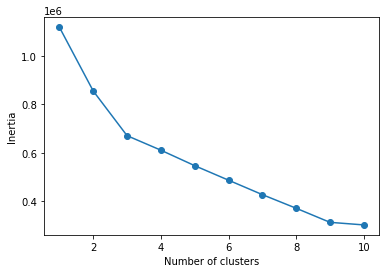

In [15]:
# Decide the best k: inertia criterion
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', n_init=10, max_iter=200, tol=1e-04, random_state=777)
    kmeans.fit(train_scaled)
    inertia.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### K-Means

In [16]:
# Clustering model
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=200, tol=1e-04, random_state=777)
train_cluster_kmeans = kmeans.fit_predict(train_scaled)
test_cluster_kmeans = kmeans.predict(test_scaled)
full_cluster_kmeans = kmeans.predict(full_scaled)

In [17]:
# Save clustering results to the dataframes
train_df['cluster_kmeans'] = train_cluster_kmeans
test_df['cluster_kmeans'] = test_cluster_kmeans
cluster_df['cluster_kmeans'] = full_cluster_kmeans

### K-Means Results

In [18]:
# check cluster proportions - train 
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, train_df['cluster_kmeans'].value_counts()[i]))

Cluster 0 has 23678 customers.
Cluster 1 has 23114 customers.
Cluster 2 has 23208 customers.


In [19]:
# check cluster proportions - test
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, test_df['cluster_kmeans'].value_counts()[i]))

Cluster 0 has 10059 customers.
Cluster 1 has 10016 customers.
Cluster 2 has 9925 customers.


In [20]:
# check cluster proportions - full
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, cluster_df['cluster_kmeans'].value_counts()[i]))

Cluster 0 has 33737 customers.
Cluster 1 has 33130 customers.
Cluster 2 has 33133 customers.


In [21]:
# check out the clusters in training set
train_df.groupby(by='cluster_kmeans').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon
cluster_kmeans,,,,,,,,,,,,,,,,
0,1.740561,1.793141,0.052580,0.323042,0.033449,0.396275,0.031886,0.028085,0.020356,0.399823,0.027874,0.032393,0.029859,0.992609,0.006631,0.000760
1,0.342779,2.254261,1.911482,0.123605,0.200398,0.039673,0.203037,0.038418,0.200485,0.038894,0.042182,0.197586,0.039327,0.007182,0.028684,0.964134
2,3.495002,3.678128,0.183127,3.291624,0.027792,0.028352,0.028999,0.273613,0.028309,0.026672,0.268657,0.039771,0.277835,0.004955,0.990391,0.004654


In [22]:
# check out the clusters in testing set
test_df.groupby(by='cluster_kmeans').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon
cluster_kmeans,,,,,,,,,,,,,,,,
0,1.721443,1.770355,0.048911,0.316831,0.029128,0.408092,0.031017,0.029029,0.018889,0.392882,0.030818,0.031613,0.028532,0.992842,0.006959,0.000199
1,0.335962,2.241913,1.905950,0.119010,0.202077,0.039836,0.198383,0.043431,0.202875,0.038339,0.037240,0.200080,0.037740,0.006789,0.030052,0.963159
2,3.518086,3.695617,0.177531,3.312040,0.029824,0.031134,0.027305,0.272846,0.031436,0.028816,0.270428,0.038589,0.269622,0.005945,0.989421,0.004635


In [23]:
# check out the clusters in full set
cluster_df.groupby(by='cluster_kmeans').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon
cluster_kmeans,,,,,,,,,,,,,,,,
0,1.734861,1.786347,0.051486,0.321190,0.032161,0.399798,0.031627,0.028366,0.019919,0.397753,0.028752,0.032161,0.029463,0.992679,0.006729,0.000593
1,0.340718,2.250528,1.909810,0.122216,0.200906,0.039722,0.201630,0.039934,0.201207,0.038726,0.040688,0.198340,0.038847,0.007063,0.029097,0.963839
2,3.501917,3.683367,0.181451,3.297739,0.028401,0.029185,0.028491,0.273383,0.029246,0.027314,0.269188,0.039417,0.275375,0.005252,0.990101,0.004648


### GMM

In [24]:
gmm = mixture.GaussianMixture(n_components=3).fit(train_scaled)
train_cluster_gmm = gmm.predict(train_scaled)
test_cluster_gmm = gmm.predict(test_scaled)
full_cluster_gmm = gmm.predict(full_scaled)

In [25]:
# Save clustering results to the dataframes
train_df['cluster_gmm'] = train_cluster_gmm
test_df['cluster_gmm'] = test_cluster_gmm
cluster_df['cluster_gmm'] = full_cluster_gmm

### GMM Results

In [26]:
# check cluster proportions - train 
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, train_df['cluster_gmm'].value_counts()[i]))

Cluster 0 has 22411 customers.
Cluster 1 has 23784 customers.
Cluster 2 has 23805 customers.


In [27]:
# check cluster proportions - test
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, test_df['cluster_gmm'].value_counts()[i]))

Cluster 0 has 9695 customers.
Cluster 1 has 10114 customers.
Cluster 2 has 10191 customers.


In [28]:
# check cluster proportions - full
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, cluster_df['cluster_gmm'].value_counts()[i]))

Cluster 0 has 32106 customers.
Cluster 1 has 33898 customers.
Cluster 2 has 33996 customers.


In [29]:
# check out the clusters in training set
train_df.groupby(by='cluster_gmm').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon,cluster_kmeans
cluster_gmm,,,,,,,,,,,,,,,,,
0,0.359957,2.263264,1.903306,0.137120,0.197939,0.041230,0.200437,0.040070,0.197492,0.040293,0.044576,0.196377,0.041587,0.0,0.0,1.0,1.004016
1,1.749748,1.819374,0.069627,0.323495,0.035024,0.390851,0.033047,0.029852,0.022326,0.394341,0.029305,0.034309,0.030945,1.0,0.0,0.0,0.016650
2,3.384373,3.609788,0.225415,3.198110,0.033606,0.031002,0.035413,0.264440,0.034279,0.029532,0.259357,0.043688,0.268683,0.0,1.0,0.0,1.958958


In [30]:
# check out the clusters in testing set
test_df.groupby(by='cluster_gmm').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon,cluster_kmeans
cluster_gmm,,,,,,,,,,,,,,,,,
0,0.351831,2.250954,1.899123,0.131924,0.199175,0.041258,0.196287,0.046003,0.200619,0.039092,0.038164,0.199278,0.040124,0.0,0.0,1.0,1.004538
1,1.734329,1.798794,0.064465,0.318371,0.030947,0.403105,0.031738,0.030651,0.020862,0.386494,0.032430,0.033815,0.029958,1.0,0.0,0.0,0.018390
2,3.399666,3.623393,0.223727,3.213816,0.036208,0.032970,0.033952,0.262879,0.037092,0.032774,0.261898,0.042292,0.259935,0.0,1.0,0.0,1.956727


In [31]:
# check out the clusters in full set
cluster_df.groupby(by='cluster_gmm').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon,cluster_kmeans
cluster_gmm,,,,,,,,,,,,,,,,,
0,0.357503,2.259547,1.902043,0.135551,0.198312,0.041238,0.199184,0.041861,0.198436,0.039930,0.042640,0.197253,0.041145,0.0,0.0,1.0,1.004174
1,1.745147,1.813234,0.068087,0.321966,0.033807,0.394507,0.032657,0.030090,0.021889,0.392000,0.030238,0.034161,0.030651,1.0,0.0,0.0,0.017169
2,3.388958,3.613866,0.224909,3.202818,0.034386,0.031592,0.034975,0.263972,0.035122,0.030504,0.260119,0.043270,0.266061,0.0,1.0,0.0,1.958289


### Save the Results

In [32]:
# Dataframe with dummy variables
cluster_df_result = pd.concat([ticket_id, cluster_df], axis=1)
cluster_df_result.to_csv('Results_dummy.csv')
cluster_df_result.head()

,ticket_id,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,meal_time_Late Night,meal_time_Night,meal_time_Noon,cluster_kmeans,cluster_gmm
0,0x872a40,2.0,2.0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,2,2
1,0x598eb3,1.0,3.0,2.0,0.0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,0x5646c2,0.0,3.0,3.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,0x4022cf,0.0,4.0,4.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
4,0x7a39d9,5.0,5.0,0.0,5.0,0,0,0,0,0,0,1,0,0,0,1,0,2,2


In [33]:
# Dataframe with customer information
customer_df['cluster_kmeans'] = full_cluster_kmeans
customer_df['cluster_gmm'] = full_cluster_gmm
customer_df_result = pd.concat([ticket_id, customer_df], axis=1)
customer_df_result.to_csv('Results.csv')
customer_df_result.head()

,ticket_id,location,burger,fries,salad,shake,meal_time,cluster_kmeans,cluster_gmm
0,0x872a40,4,2.0,2.0,0.0,2.0,Night,2,2
1,0x598eb3,5,1.0,3.0,2.0,0.0,Noon,1,0
2,0x5646c2,3,0.0,3.0,3.0,0.0,Noon,1,0
3,0x4022cf,4,0.0,4.0,4.0,0.0,Noon,1,0
4,0x7a39d9,7,5.0,5.0,0.0,5.0,Night,2,2
